<a href="https://colab.research.google.com/github/futureDataInfo/transformers/blob/main/simple_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import json
import re
import shutil
import xml.etree.ElementTree as ET
import math
from datetime import datetime
import cv2
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop,Adam
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D,\
                MaxPooling2D, Dropout, BatchNormalization,Input, concatenate
from keras.models import Model, Sequential
from tensorflow.keras.layers import Dropout

from sklearn.model_selection import KFold, StratifiedKFold

from imblearn.over_sampling import SMOTE
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix, accuracy_score

Mounted at /content/drive


In [2]:
data_path="/content/drive/My Drive/outputb/"
dir=os.listdir(data_path)
resized_path="/content/drive/My Drive/resized_456/"
dynamo=pd.read_csv('/content/dynamo_5_11.csv')

In [3]:
def get_flat_image_keys(ind):
    num_images=len(df_image.iloc[ind,1].split(','))
    image_lst=[]
    for num in range(num_images):
        rec=df_image.iloc[ind,1].split(',')[num].split(":")[2].split("}")[0][:-1]
        if rec.split('/')[0]=='564c509c-acb6-453c-968d-26f807050cf0':
            new_rec_1='mita'
        elif rec.split('/')[0]=='aa6080d1-3719-4a77-afc8-6569f0a69b91':
            new_rec_1='pankaj'
        elif rec.split('/')[0]=='e22bc935-c380-4390-8055-9f5b84c9b4aa':
            new_rec_1='riju'
        elif rec.split('/')[0]=='ec068837-df07-4e96-8de1-b52cc48e8dcd':
            new_rec_1='mili'
        elif rec.split('/')[0]=='80063d3b-4da2-46c4-a3be-8fc71a915248':
            new_rec_1='kaushik'
        elif rec.split('/')[0]=='2fabb9fa-e0a1-4291-981c-93970b9d563d':
            new_rec_1='shiba'
        else:
            new_rec_1=rec.split('/')[0]
        new_rec=new_rec_1+'-'+rec.split('/')[2]+'-'+rec.split('/')[3]
        image_lst.append(new_rec)
        idx=df_image.filter(items=[ind], axis=0)['idx'].values[0].astype(int)
    return  idx,list(set(image_lst))


#### create df_image and df_other from dynamo db

dynamo_df=dynamo[~dynamo['agentid'].isin(['Op', 'test','1', 'C', 'mou', 'Mou','S','Jk', 'Ty','2'])]
dynamo_df_good=dynamo_df[~dynamo_df['tested_hb'].isna()]
dynamo_df_good=dynamo_df_good[(dynamo_df_good['tested_hb']!='11. 3')&(dynamo_df_good['tested_hb']!='90')\
                              &(dynamo_df_good['tested_hb']!='15..0')]
df=dynamo_df_good[['imageKey', 'preg', 'sex', 'tested_hb','pid','age']]
df.reset_index(inplace=True)
df=df.rename(columns={'index':'idx'})
df_image=df[['idx','imageKey']]
df_other=df[['idx','preg','sex','age','tested_hb']]

### create flat image key table

image_dict={}
for ind in range(len(df_image)):
    k,v=get_flat_image_keys(ind)
    image_dict[k]=v
df_flat_image=pd.DataFrame(
              [(k,i) for k,v in image_dict.items() for i in v],
                columns=['ind', 'image_keys'])

df_flat_image['mod_key']=[df_flat_image['image_keys'][i][:-5] for i in range(len(df_flat_image))]
df_dir=pd.DataFrame(zip(dir,[dir[i][:-16] for i in range(len(dir))]),columns=['raw_image','mod_key'])
df_final=pd.merge(df_flat_image,df_dir,on='mod_key')
df_ready=pd.merge(df_final,df_other,left_on=['ind'],right_on=['idx'])[['raw_image','tested_hb']].reset_index(drop=True)
df_ready['tested_hb']=df_ready['tested_hb'].str.replace('. ','.')
#df_ready=df_ready[~df_ready['tested_hb'].isin(['13. 7','12. 7','15. 9','12. 6'])]
df_ready['tested_hb']=df_ready['tested_hb'].astype(np.float32)
df_ready['class']=np.where(df_ready['tested_hb']<=10.5,'anemic','no_anemic')
print(df_ready.dtypes)
print(len(df_ready))

raw_image     object
tested_hb    float32
class         object
dtype: object
732


<ipython-input-3-1604fe8cd5fb>:52: FutureWarning: The default value of regex will change from True to False in a future version.
  df_ready['tested_hb']=df_ready['tested_hb'].str.replace('. ','.')


In [ ]:
#from sklearn.model_selection import train_test_split
#df_train, df_test = train_test_split(df_ready,train_size=0.8, shuffle=True)
#print(len(df_test[df_test['class']=='anemic']))

34


In [4]:
def recreate_train_test(fld):
  df=pd.DataFrame()
  df['raw_image']=os.listdir(resized_path+fld)
  return df

df_test=pd.concat([recreate_train_test('validation/anemic'),\
                    recreate_train_test('validation/no_anemic')])
df_ready_cp=df_ready.copy()
df_test=pd.merge(df_test,df_ready_cp,left_on=['raw_image'],right_on=['raw_image']).sample(frac = 1)

df_test['raw_image']=np.where(df_test['class']=='anemic',resized_path+'validation/anemic/'+df_test['raw_image'],\
                                                resized_path+'validation/no_anemic/'+df_test['raw_image'])

df_train=pd.concat([recreate_train_test('training/anemic'),\
                    recreate_train_test('training/no_anemic')])
df_train=pd.merge(df_train,df_ready_cp,left_on=['raw_image'],right_on=['raw_image']).sample(frac = 1)

df_train['raw_image']=np.where(df_train['class']=='anemic',resized_path+'training/anemic/'+df_train['raw_image'],\
                                                resized_path+'training/no_anemic/'+df_train['raw_image'])

print(len(df_train))
print(len(df_test))

585
147


In [5]:
IMAGE_SIZE=456

In [ ]:
### Onetime image resizing and loading
"""
df=df_train[df_train['class']=='anemic']
target_path=resized_path+'training/anemic/'
for i in range(len(df)):
  im=cv2.cvtColor(cv2.imread(data_path+df.iloc[(i,0)]), cv2.COLOR_BGR2RGB)
  resized_im=cv2.resize(im,(IMAGE_SIZE,IMAGE_SIZE),interpolation = cv2.INTER_LINEAR)
  cv2.imwrite(target_path+df.iloc[(i,0)],cv2.cvtColor(resized_im, cv2.COLOR_BGR2RGB))
  """

In [ ]:
##print(len(os.listdir(resized_path+'training/anemic/')))
#print(len(os.listdir(resized_path+'training/no_anemic/')))
#print(len(os.listdir(resized_path+'validation/anemic/')))
#print(len(os.listdir(resized_path+'validation/no_anemic/')))

In [6]:
X_train=[]
for ind in range(len(df_train)):
    im_path=df_train.iloc[(ind,0)]
    X_train.append(cv2.cvtColor(cv2.imread(im_path), cv2.COLOR_BGR2RGB))
X_test=[]
for ind in range(len(df_test)):
    im_path=df_test.iloc[(ind,0)]
    X_test.append(cv2.cvtColor(cv2.imread(im_path), cv2.COLOR_BGR2RGB))

In [7]:
y_train=np.where(df_train['class']=='anemic',0,1)
y_test=np.where(df_test['class']=='anemic',0,1)
smt = SMOTE(random_state=42)
X_smote, y_smote = smt.fit_resample(np.array(X_train).reshape(len(X_train),\
                                            IMAGE_SIZE * IMAGE_SIZE * 3), y_train)
X_smote=X_smote.reshape(-1,IMAGE_SIZE,IMAGE_SIZE,3)
y_smote= to_categorical(y_smote, num_classes = 2)
y_test = to_categorical(y_test, num_classes = 2)
print(len(X_smote))
print(len(y_smote))
print(len(X_test))
print(len(y_test))

936
936
147
147


In [8]:
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.30),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.2),
    ],
    name="img_augmentation",
)

In [28]:
def build_model(num_classes):
    inputs = keras.layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3))
    scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
    x = scale_layer(inputs)
    x = img_augmentation(x)

    #x = tf.keras.layers.Conv2D(3, 5, activation='relu')(x)
    #print(x.shape)
    x = tf.keras.layers.Conv2D(12, 5, activation='relu')(x)
    x = tf.keras.layers.Conv2D(12, 5, activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    #print(x.shape)
    x = tf.keras.layers.Conv2D(24, 5, activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    #print(x.shape)
    x = tf.keras.layers.Conv2D(48, 5, activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    #print(x.shape)
    x = tf.keras.layers.Conv2D(72, 5, activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    #print(x.shape)
    x = tf.keras.layers.Conv2D(96, 5, activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    #print(x.shape)
    #x=  keras.layers.Flatten(input_shape=(10*10*96))(x)
    x= tf.reshape(x, [-1, 10*10*96])
    #x =keras.layers.Dense(1024, activation='relu')(x)
    #x =keras.layers.Dense(512, activation='relu')(x)
    #x = keras.layers.Dropout(0.25)(x)
    #x =keras.layers.Dense(256, activation='relu')(x)
    #x = keras.layers.Dropout(0.2)(x)
    x =keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dropout(0.2)(x)
    #x =keras.layers.Dense(64, activation='relu')(x)
    #x = keras.layers.Dropout(0.2)(x)
    x =keras.layers.Dense(32, activation='relu')(x)
    #x = keras.layers.Dropout(0.2)(x)
    #x =keras.layers.Dense(16, activation='relu')(x)
    #x = keras.layers.Dropout(0.2)(x)

    #top_dropout_rate = 0.2
    #x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(2, activation="sigmoid")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs)
    #optimizer =tf.keras.optimizers.SGD(learning_rate = 1e-4,\
     #                                  momentum = 0.9,weight_decay=0.04)   
    #tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [29]:
model=build_model(2)
print(model.summary())

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 456, 456, 3)]     0         
                                                                 
 rescaling_7 (Rescaling)     (None, 456, 456, 3)       0         
                                                                 
 img_augmentation (Sequentia  (None, 456, 456, 3)      0         
 l)                                                              
                                                                 
 conv2d_40 (Conv2D)          (None, 452, 452, 12)      912       
                                                                 
 conv2d_41 (Conv2D)          (None, 448, 448, 12)      3612      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 224, 224, 12)     0         
 g2D)                                                      

In [11]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-6)

In [30]:
EPOCHS = 50
history = model.fit(X_smote,y_smote,batch_size = 32,
                    epochs=EPOCHS,
                    validation_data=(np.array(X_test),y_test),
                    validation_batch_size=32,
                    verbose=1,
                    callbacks = [learning_rate_reduction])

Epoch 1/50
30/30 [==============================] - 16s 238ms/step - loss: 0.6872 - accuracy: 0.7222 - val_loss: 0.5885 - val_accuracy: 0.8027 - lr: 0.0010
Epoch 2/50
30/30 [==============================] - 6s 204ms/step - loss: 0.4921 - accuracy: 0.7885 - val_loss: 0.5081 - val_accuracy: 0.8095 - lr: 0.0010
Epoch 3/50
30/30 [==============================] - 6s 205ms/step - loss: 0.5236 - accuracy: 0.7650 - val_loss: 0.9257 - val_accuracy: 0.5374 - lr: 0.0010
Epoch 4/50
30/30 [==============================] - 6s 207ms/step - loss: 0.5208 - accuracy: 0.7639 - val_loss: 0.6605 - val_accuracy: 0.7279 - lr: 0.0010
Epoch 5/50
30/30 [==============================] - ETA: 0s - loss: 0.5145 - accuracy: 0.7799
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
30/30 [==============================] - 6s 203ms/step - loss: 0.5145 - accuracy: 0.7799 - val_loss: 1.2456 - val_accuracy: 0.5646 - lr: 0.0010
Epoch 6/50
30/30 [==============================] - 6s 205ms/step

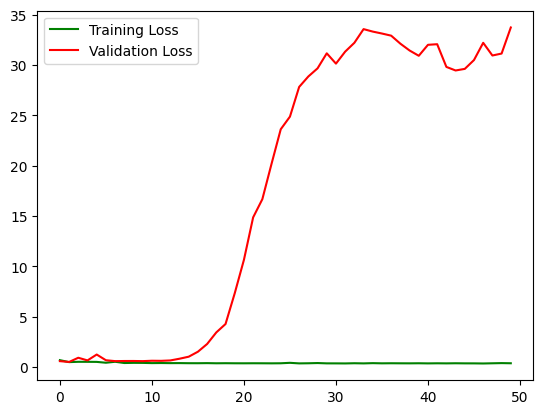

In [31]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(loss,color = 'green',label = 'Training Loss')
plt.plot(val_loss,color = 'red',label = 'Validation Loss')
plt.legend()

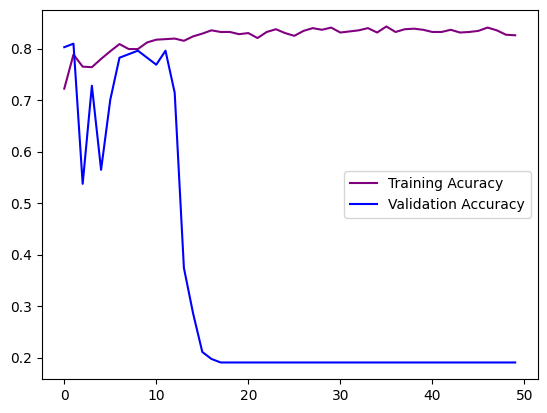

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure()
plt.plot(acc,color = 'purple',label = 'Training Acuracy')
plt.plot(val_acc,color = 'blue',label = 'Validation Accuracy')
plt.legend()